<a href="https://colab.research.google.com/github/Mobad225/Spectral-Clustering/blob/master/Spectal_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1)

### Min cut : Min $\sum_{i \in A, j \in B}$ $w_{i,j}$
### Normalized cut : Min cut * ($\frac{1}{Vol_{A}}$ + $\frac{1}{Vol_{B}}$)
### Where $Vol_{X}$ Is the *degree* of Component X

### Since the weights is the affinity, It does not need to be changed.

## $Mincut_{C_{1}}$ = 20 + 10 + 10 = 40
## $Mincut_{C_{2}}$ = 20 + 10 + 10 + 10 = 50
## If we will make a min cut, We would choose $C_{1}$

## Normalized Cut:
## $C_{1}$ = 40 * $(\frac{1}{19} + \frac{1}{5})$ = 10.11
## $C_{2}$ = 50 * $(\frac{1}{10} + \frac{1}{14})$ = 8.57
## If we will make a normalized cut, We would choose $C_{2}$

# Question 2) Implementation of K-way Normalized cut

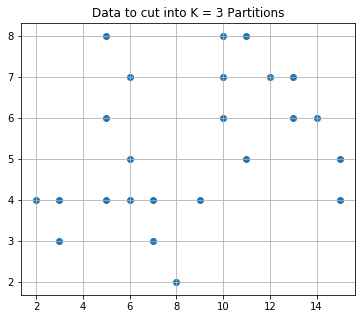

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([(5, 10, 11, 6, 10, 12 ,13, 5, 10, 13, 14, 6, 11, 15, 2, 3, 5,
                  6, 7, 9, 15, 3, 7 , 8), (8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 5,
                                           5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2)])
data = data.T
plt.figure(figsize=(6,5))
plt.scatter(data[:,0], data[:,1])
plt.title('Data to cut into K = 3 Partitions')
plt.grid(True)
plt.show()
plt.close()

### RBF Kernel to calculate edge weights

In [0]:
def RBF(node1, node2, gamma):
  diff = node1 - node2
  weight = -1 * gamma * diff.dot(diff)
  return np.exp(weight)

### Creating the adjacency matrices for each gamma

In [0]:
gammas = [0.01, 0.1, 1, 10]
adj = np.empty((len(data), len(data), len(gammas)))
for k in range(len(gammas)):
  for i  in range(len(data)):
    for j in range(i, len(data)):
      adj[i][j][k] = adj[j][i][k] = RBF(data[i], data[j], gammas[k])

### Function to check if a graph is connected

In [0]:
def dfs(adj, vis, u, EPS, dim = 0):
  vis[u] = 1
  for i in range(len(adj)):
    if adj[u][i][dim] > EPS and vis[i] == 0:
      dfs(adj, vis, i, EPS, dim = dim)

In [0]:
def is_connected(adj, gamma = 0, EPS = 0.001):
  vis = np.zeros(len(adj))
  dfs(adj, vis, 0, EPS, dim = gamma)
  for i in range(1, len(adj)):
    if vis[i] == 0:
      
      return False
  return True

In [6]:
for i in range(len(gammas)):
  print('for gamma = {:.2f}, The graph is connected : '.format(gammas[i]),
        is_connected(adj, gamma = i))

for gamma = 0.01, The graph is connected :  True
for gamma = 0.10, The graph is connected :  True
for gamma = 1.00, The graph is connected :  True
for gamma = 10.00, The graph is connected :  False


### Another representation of the Adjacency Matrix

In [0]:
A = np.zeros((len(gammas), len(adj), len(adj)))
for i in range(len (adj)):
  for j in range(i, len(adj)):
    for k in range(len(gammas)):
      A[k][i][j] = A[k][j][i] = adj[i][j][k]

### Degree Matrix

In [0]:
D = np.array([np.diag(A[x].sum(axis = 1)) for x in range(len(gammas))])

### Laplacian Matrix

In [0]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [0]:
L = np.array([D[x] - A[x] for x in range(len(gammas))])

### Normalized Laplacian Asymmetric Matrix

In [0]:
D_inv = np.array([np.linalg.pinv(D[x]) for x in range(len(gammas))])
La = np.array([D_inv[x].dot(L[x]) for x in range(len(gammas))])

### Eigenvalues and Eigenvectors, Take Highest K

In [0]:
k = 3
Eigenvalues, Eigenvectors = np.linalg.eig(La)
Eigenvalues, Eigenvectors = np.real(Eigenvalues), np.real(Eigenvectors)
W = np.empty((len(gammas), len(adj), k))
for i in range(len(gammas)):
  Eigenvectors[i] = Eigenvectors[i][:,np.argsort(Eigenvalues[i])]
  Eigenvalues[i] = Eigenvalues[i][np.argsort(Eigenvalues[i])]
  W[i] = Eigenvectors[i][:,:k]

### Normalize the ROWS of W

In [0]:
from sklearn import preprocessing

W_normalized = np.empty(W.shape)
for i in range(len(gammas)):
  W_normalized[i] = preprocessing.normalize(W[i], norm="l1")

### K-means on the Resultant Matrix

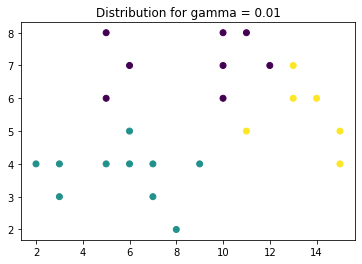

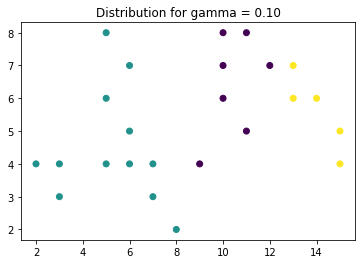

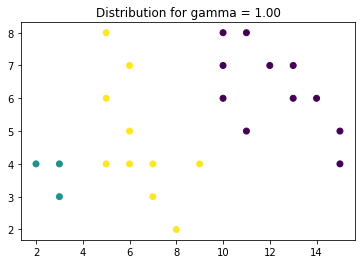

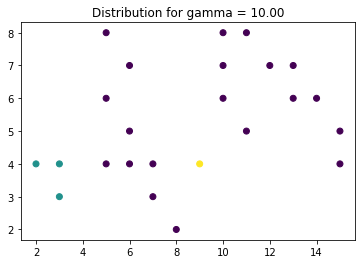

In [14]:
from sklearn.cluster import KMeans

for i in range(len(gammas)):
  kmeans = KMeans(n_clusters = k, random_state=0).fit(W[i])
  pred = kmeans.labels_
  plt.scatter(data[:,0], data[:,1], c = pred)
  plt.title('Distribution for gamma = {:.2f}'.format(gammas[i]))
  plt.show()
  plt.close()
  print()

### Plotting the 3d normalized Eigenvectors

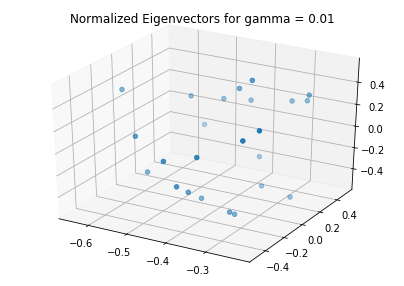

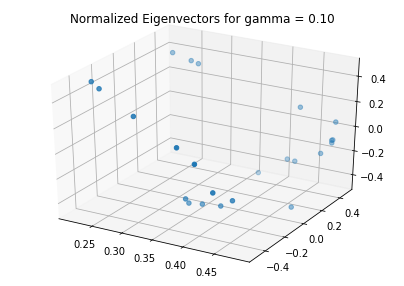

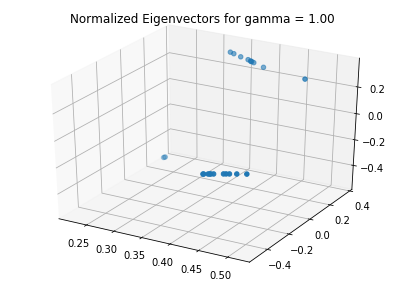

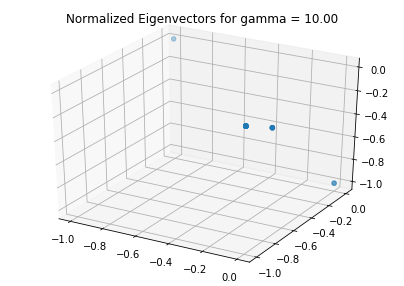

In [15]:
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(gammas)):
  fig = plt.figure(figsize=(7,5))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(W_normalized[i][:,0], W_normalized[i][:,1], W_normalized[i][:,2])
  plt.title('Normalized Eigenvectors for gamma = {:.2f}'.format(gammas[i]))
  plt.show()
  plt.close()

## Question 2) b)

### Function to get new Adjancency Matrix (Only Nearest K Neighbors)

In [0]:
def get_knn_adjacency(k):
  distanceMatrix = np.sqrt(np.sum((data[np.newaxis,:] - data[:, np.newaxis])**2, axis = -1))
  new_adj = np.zeros((len(data), len(data)))
  for i in range (len(data)):
    ids = np.argsort(distanceMatrix[i])
    for j in range(k):
      new_adj[i][ids[j]] = 1
  return new_adj

In [0]:
KNN_adj = get_knn_adjacency(3)

### Getting Degree Matrix

In [0]:
KNN_D = np.diag(KNN_adj.sum(axis = 1))

### Getting Laplacian Matrix & Laplacian Normalized Matrix $L^{a}$

In [0]:
KNN_L = KNN_D - KNN_adj
KNN_D_inv = np.linalg.pinv(KNN_D)
KNN_La = KNN_D_inv.dot(KNN_L)

### Eigenvalues & Eigenvectors

In [0]:
k = 3
KNN_Eigenvalues, KNN_Eigenvectors = np.linalg.eig(KNN_La)
KNN_Eigenvalues, KNN_Eigenvectors = np.real(KNN_Eigenvalues), np.real(KNN_Eigenvectors)
KNN_W = KNN_Eigenvectors[:,:k]

### Normalizing Eigenvectors

In [0]:
KNN_W_normalized = preprocessing.normalize(KNN_W, norm="l1")

### Visualizing Results

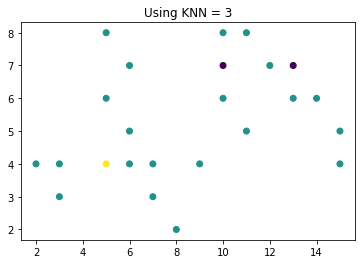

In [22]:
kmeans = KMeans(n_clusters = k, random_state=0).fit(KNN_W)
KNN_pred = kmeans.labels_
plt.scatter(data[:,0], data[:,1], c = KNN_pred)
plt.title('Using KNN = 3')
plt.show()
plt.close()

### Plotting the 3d Eigenvectors

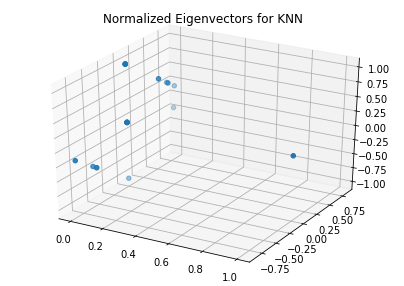

In [23]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(KNN_W_normalized[:,0], KNN_W_normalized[:,1], KNN_W_normalized[:,2])
plt.title('Normalized Eigenvectors for KNN')
plt.show()
plt.close()

# BONUS

### A much better dataset for testing... :)

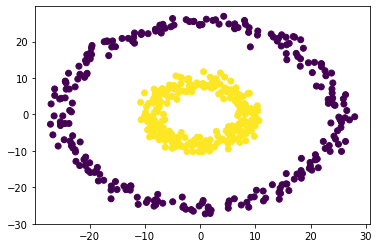

In [35]:
from sklearn import datasets

n_samples = 500
data, y = datasets.make_circles(n_samples=n_samples, factor=0.35, noise=.05)
data = 25 * data
plt.scatter(data[:,0], data[:,1], c = y)
plt.show()
plt.close()

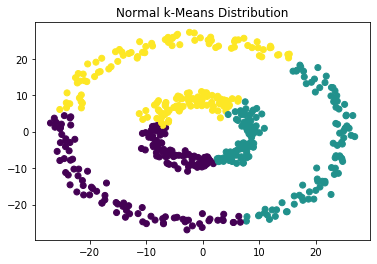

In [25]:
kmeans = KMeans(n_clusters = k, random_state=0).fit(data)
pred = kmeans.labels_
plt.scatter(data[:,0], data[:,1], c = pred)
plt.title('Normal k-Means Distribution')
plt.show()
plt.close()

## Now using the spectral clustering, Normalized cut

### Finding the adjacency list using RBF Kernel

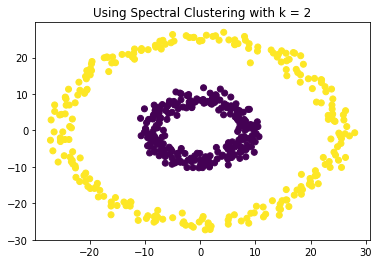

In [53]:
gamma = 0.05
adj = np.empty((len(data), len(data)))
for i  in range(len(data)):
  for j in range(i, len(data)):
    adj[i][j] = adj[j][i] = RBF(data[i], data[j], gamma)
D = np.diag(adj.sum(axis = 1))
L = D - adj
D_inv = np.linalg.pinv(D)
La = D_inv.dot(L)
k = 2
Eigenvalues, Eigenvectors = np.linalg.eig(La)
Eigenvalues, Eigenvectors = np.real(Eigenvalues), np.real(Eigenvectors)
W = Eigenvectors[:,:k]
W_normalized = preprocessing.normalize(W, norm="l1")
kmeans = KMeans(n_clusters = k, random_state=0).fit(W)
pred = kmeans.labels_
plt.scatter(data[:,0], data[:,1], c = pred)
plt.title('Using Spectral Clustering with k = 2')
plt.show()
plt.close()